In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
from astropy.io import fits
from PIL import Image
from scipy.misc import toimage
import pandas as pd
import seaborn; seaborn.set()  # set plot styles

import sys
sys.path.insert(0,'../rficnn/')
import rficnn as rfc

%matplotlib inline

In [2]:
sim_files = glob.glob('/home/anke/HIDE_simulations/hide_sims_train/calib_1year/*.fits') + glob.glob('/home/anke/HIDE_simulations/hide_sims_train/calib_1year/*.h5')
l = len(sim_files)
file_set = sim_files[:20]
l

131

In [7]:
nx,ny = 276, 14400
dp = rfc.read_part_chunck_sdfits(file_set[0],label_tag='RFI')
dp = np.array(dp)
data, rfi = dp

In [4]:
def ecdf(file):
    ext = file.split('.')[-1]
    if ext == 'fits':
        data, rfi = rfc.read_part_chunck_sdfits(file, label_tag='RFI')
    elif ext == 'h5':
        data, rfi = rfc.read_part_chunck_hdf5(filename, label_tag)
    rfi[np.logical_and(rfi<0,data<0)] = 0
    data[np.logical_and(rfi<0,data<0)] = 0
    rfi[rfi<0] = 0
    rfi[data<0] = 0
    data[data<0] = 0
    rfi = np.array(rfi)
    rfi = np.reshape(rfi,-1)
    count = len(rfi)
    rfi_sorted = np.sort(rfi)
    y = np.arange(1, len(rfi_sorted)+1)/count # fraction of the array
    return rfi_sorted,y

In [8]:
# find 2 threshold

rfi[np.logical_and(rfi<0,data<0)] = 0
data[np.logical_and(rfi<0,data<0)] = 0
rfi[rfi<0] = 0
rfi[data<0] = 0
data[data<0] = 0
rfi = np.array(rfi)
rfi = np.reshape(rfi,-1)
count = len(rfi) 
rfi_sorted = np.sort(rfi)
y = np.arange(1, len(rfi_sorted)+1)/count    

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [26]:
def find_threshold(rfi_sorted, y, values):
    thresholds = []
    for i in values:
        thresholds.append(rfi_sorted[find_nearest(y, i)])
    return thresholds

rfi_sorted[find_nearest(y, 0.333)]

5.0953745e-13

In [27]:
find_threshold(rfi_sorted, y, [0.333,0.666])

[5.0953745e-13, 0.0035987594]

In [5]:
def plot_rfi_ecdf(file):
    '''Plots the Empirical Cumulative Distribution Function for all the RFI
    Able to read off the thresholds'''
    ext = file.split('.')[-1]
    if ext == 'fits':
        rfi = rfc.read_part_chunck_sdfits(file, label_tag='RFI')[1]
    elif ext == 'h5':
        rfi = rfc.read_part_chunck_hdf5(filename, label_tag)[1]
    rfi[np.logical_and(rfi<0,data<0)] = 0
    data[np.logical_and(rfi<0,data<0)] = 0
    rfi[rfi<0] = 0
    rfi[data<0] = 0
    data[data<0] = 0
    rfi = np.array(rfi)
    rfi = np.reshape(rfi,-1)
    count = len(rfi) # amount of data in array that have value bigger than zero
    rfi_sorted = np.sort(rfi)
    y = np.arange(1, len(rfi_sorted)+1)/count
    
    import matplotlib.pyplot as plt
    #plt.figure(figsize=(8,6))
    plt.title('ECDF')
    plt.xlabel('RFI amplitude (Jy)')
    plt.ylabel('Fraction of dataset')
    plt.xscale('log')
    plt.margins(0.02)
    plt.plot(rfi_sorted, y, marker='.', linestyle=None)
    plt.savefig('ECDF.png', format='png')


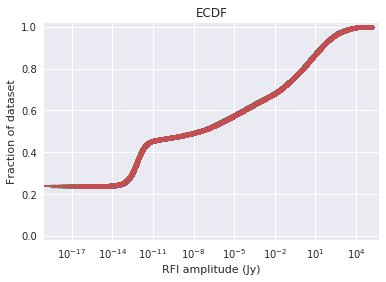

In [8]:
for file in file_set[0:3]:
    plot_rfi_ecdf(file)

In [6]:
hist, bin_edges = np.histogram(rfi_sorted[~rfi_sorted.mask],bins='auto')

In [ ]:
plt.bar(bin_edges[:-1], hist, width = 1)
#plt.xlim(min(bin_edges), max(bin_edges))

---

In [ ]:
# Alireza code

bins = 100

min_ratio= 1e-4
max_ratio=np.inf

rfi_ratio=abs(100*rfi/data) # percentage rfi 
rfi_accept = (min_ratio<rfi_ratio) & (rfi_ratio<max_ratio) #

print(rfi_accept)

'''Return a copy of the array collapsed into one dimension.'''
r2d = rfi_ratio[rfi_accept].flatten() #np.clip(.reshape(-1),0,200) 

r=[1,200]
hist, bin_edges = np.histogram(r2d,bins=bins,range=r)
print( 'percentage of pixels in range: ',r,'is', 100.0*hist.sum()/float(len(r2d)) ) 
bin_cents = [0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(bins)]

plt.xlabel('Percentage RFI')
plt.ylabel('Cumulative Sum')
plt.plot(bin_cents,np.cumsum(hist))
plt.xscale('log')
plt.yscale('log')

In [ ]:
def plot_rfi_cdf(file,min_ratio=1e-4, max_ratio=np.inf, bins=100, r=[1,2]):
    '''Plots the Cumulative Distribution function of RFI percentage'''
    h = read_chunck_sdfits_modified(file, label_tag='RFI')
    h = np.array(h)
    rfi = h[1]
    data = h[0]
    per_rfi = abs(100*rfi/data)
    #per_rfi = np.reshape(per_rfi,(-1))
    per_rfi_sorted = np.sort(per_rfi)
    rfi_accept = (min_ratio<per_rfi) & (per_rfi<max_ratio)
    r2d = rfi_ratio[rfi_accept].flatten() #np.clip(.reshape(-1),0,200) 

    hist, bin_edges = np.histogram(r2d,bins=bins,range=r)
    print( 'percentage of pixels in range: ',r,'is', 100.0*hist.sum()/float(len(r2d)) ) 
    bin_cents = [0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(bins)]

    plt.xlabel('Percentage RFI')
    plt.ylabel('Cumulative Sum')
    plt.plot(bin_cents,np.cumsum(hist))
    plt.xscale('log')
    plt.yscale('log')
    


---